#Download data

In [ ]:
import gdown
import zipfile
import os

# Đường dẫn đến file zip trên Google Drive
google_drive_link = "https://drive.google.com/uc?id=12MaWUidLC91zFaX2QEoLxEiGE-MKIIjY"

# Tải file zip từ Google Drive
output_zip = "data.zip"
gdown.download(google_drive_link, output_zip, quiet=False)

# Giải nén file zip
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall("data_folder")  # Thay "data_folder" bằng đường dẫn thư mục bạn muốn lưu trữ dữ liệu giải nén

# Xóa file zip sau khi đã giải nén
os.remove(output_zip)

Downloading...
From (original): https://drive.google.com/uc?id=12MaWUidLC91zFaX2QEoLxEiGE-MKIIjY
From (redirected): https://drive.google.com/uc?id=12MaWUidLC91zFaX2QEoLxEiGE-MKIIjY&confirm=t&uuid=2426b44a-4a77-48f8-b766-dd9a1e5644a0
To: /content/data.zip
100%|██████████| 630M/630M [00:05<00:00, 109MB/s]


#Install environment

In [ ]:
!pip install pandas geopandas rasterio pyproj scikit-learn scipy


In [ ]:
!pip install spglm


#Import

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from pyproj import Proj, transform
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
from scipy.stats import chi2
import libpysal.weights as lp
from spglm.family import Gaussian
from spglm.glm import GLM
import matplotlib.pyplot as plt

#Sol 1: create dataframe

Failed because it took too much

##AWS

###1 file

In [ ]:
from osgeo import gdal
ds = gdal.Open("/content/data_folder/Data/precipitation/obs/2019/04/01/AWS_20190401000000.tif")
myarray = np.array(ds.GetRasterBand(1).ReadAsArray())

In [ ]:
myarray.shape

(90, 250)

In [ ]:
values = myarray[(myarray != -np.inf) & (myarray != 0)]
row_indices, col_indices = np.where((myarray != -np.inf) & (myarray != 0))

# Tạo DataFrame mới từ các giá trị và vị trí của chúng
data = {'Value': values,
        'Row Position': row_indices,
        'Column Position': col_indices}
df = pd.DataFrame(data)

print(df)

    Value  Row Position  Column Position
0     0.2             3              115
1     0.8             5              114
2     0.6             6              116
3    19.0             7              115
4     1.2            15              115
5     0.8            16              109
6     0.1            20              135
7     0.2            21              109
8     0.8            23              122
9     0.2            27              118
10    2.8            30              122
11    0.2            38               96


In [ ]:
print(type(myarray[3][115]))
print(myarray[3][115])

<class 'numpy.float32'>
0.2


###1 folder

In [ ]:
import os
import numpy as np
from osgeo import gdal
import pandas as pd

# Đường dẫn tới thư mục chứa các file TIFF
folder_path = "/content/data_folder/Data/precipitation/obs/2019/04/01/"

# Hàm để lấy tên của file (loại bỏ phần đuôi .tif và tiền tố "AWS_")
def get_name(file):
    return os.path.splitext(file)[0].replace("AWS_", "")

# Hàm để đọc dữ liệu từ file TIFF và tạo dataframe
def read_tiff(file):
    tif_file = os.path.join(folder_path, file)
    ds = gdal.Open(tif_file)
    myarray = np.array(ds.GetRasterBand(1).ReadAsArray())

    # Lấy giá trị của các ô lớn hơn 0 và vị trí của chúng
    values = myarray[(myarray > 0)]
    row_indices, col_indices = np.where(myarray > 0)

    # Tạo DataFrame từ các giá trị và vị trí của chúng
    data = {'Value': values,
            'Row Position': row_indices,
            'Column Position': col_indices}
    df = pd.DataFrame(data)

    # Lấy tên của file từ đường dẫn
    file_name = get_name(file)

    # Thêm cột 'name' với giá trị tên của file
    df['name'] = file_name

    return df


In [ ]:
# Tạo dataframe tổng hợp từ tất cả các file TIFF trong thư mục
dfs = []
for file in os.listdir(folder_path):
    if file.endswith(".tif"):
        dfs.append(read_tiff(file))

# Kết hợp các dataframe lại thành một dataframe duy nhất
result_df = pd.concat(dfs, ignore_index=True)

# Hiển thị dataframe kết quả
print(result_df)

     Value  Row Position  Column Position            name
0      9.2             0              114  20190401020000
1     30.6             0              116  20190401020000
2     22.0             0              118  20190401020000
3      2.2             0              119  20190401020000
4      4.2             0              122  20190401020000
..     ...           ...              ...             ...
908    0.2            35              105  20190401050000
909    0.8            47              104  20190401050000
910    0.6            54              102  20190401050000
911    0.2            83              128  20190401050000
912    7.4            84              124  20190401050000

[913 rows x 4 columns]


In [ ]:
# Tạo file CSV từ dataframe result_df
result_df.to_csv('/content/result_df.csv', index=False)

###1 month

In [ ]:
import os
import numpy as np
from osgeo import gdal
import pandas as pd

# Hàm để đọc dữ liệu từ một thư mục ngày và tạo dataframe
def read_day_folder(day_folder):
    day_folder_path = os.path.join(month_folder_path, day_folder)
    dfs = []
    for file in os.listdir(day_folder_path):
        if file.endswith(".tif"):
            tif_file = os.path.join(day_folder_path, file)
            ds = gdal.Open(tif_file)
            myarray = np.array(ds.GetRasterBand(1).ReadAsArray())
            values = myarray[(myarray > 0)]
            row_indices, col_indices = np.where(myarray > 0)
            data = {'Value': values,
                    'Row Position': row_indices,
                    'Column Position': col_indices}
            df = pd.DataFrame(data)
            df['name'] = os.path.splitext(file)[0].replace("AWS_", "")
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

In [ ]:
# Tạo dataframe tổng hợp từ tất cả các thư mục ngày trong thư mục của tháng
dfs_month = []
# Đường dẫn tới thư mục chứa các thư mục ngày
month_folder_path = "/content/data_folder/Data/precipitation/obs/2020/10"
for day_folder in os.listdir(month_folder_path):
    if os.path.isdir(os.path.join(month_folder_path, day_folder)):
        dfs_month.append(read_day_folder(day_folder))

# Kết hợp các dataframe lại thành một dataframe duy nhất cho cả tháng
result_df_month = pd.concat(dfs_month, ignore_index=True)

# Sắp xếp lại theo cột 'name' theo giá trị tăng dần
result_df_month = result_df_month.sort_values(by='name')

# Đổi tên cột 'Value' thành 'aws'
obs_df_month = result_df_month.rename(columns={'Value': 'AWS'})

# Hiển thị dataframe kết quả
print(obs_df_month)

# Tạo file CSV từ dataframe result_df_month
#result_df_month.to_csv('/content/result_df_month.csv', index=False)


        AWS  Row Position  Column Position            name
6748   3.60             4              125  20201001000000
6726   2.90             0              122  20201001000000
6725   1.90             0              120  20201001000000
6724   1.00             0              119  20201001000000
6723   6.60             0              118  20201001000000
...     ...           ...              ...             ...
45635  0.20            53               98  20201031230000
45634  0.50            37               81  20201031230000
45633  0.05             8               88  20201031230000
45650  0.70            87              132  20201031230000
45636  0.20            58              105  20201031230000

[48994 rows x 4 columns]


Số lần xuất hiện nhiều nhất của 1 giá trị:  8823
Giá trị có số lần xuất hiện nhiều nhất là: 0.2
Giá trị nhỏ nhất là: 0.033333335
Giá trị lớn nhất là: 107.4


<Axes: >

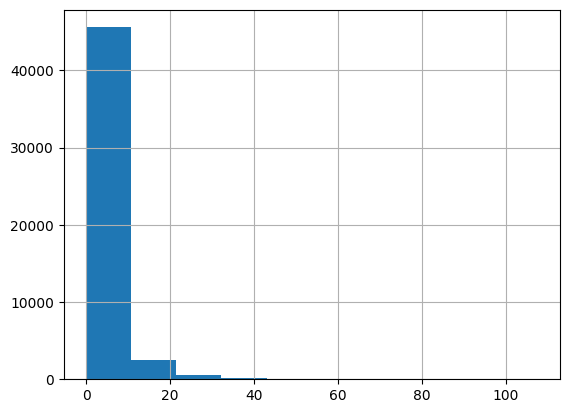

In [ ]:
value_counts = obs_df_month['AWS'].value_counts()

print("Số lần xuất hiện nhiều nhất của 1 giá trị: ", value_counts.max())

# Tìm giá trị có số lần xuất hiện nhiều nhất
most_common_value = obs_df_month['AWS'].value_counts().idxmax()

print("Giá trị có số lần xuất hiện nhiều nhất là:", most_common_value)

# Tìm giá trị lớn nhất trong cột 'Value'
min_value = obs_df_month['AWS'].min()

print("Giá trị nhỏ nhất là:", min_value)

# Tìm giá trị lớn nhất trong cột 'Value'
max_value = obs_df_month['AWS'].max()

print("Giá trị lớn nhất là:", max_value)

obs_df_month['AWS'].hist()

### 1 year

####2019

#####Value > 0

In [ ]:
import os
import numpy as np
from osgeo import gdal
import pandas as pd

# Đường dẫn tới thư mục chứa các thư mục tháng
months_folder_path = "/content/data_folder/Data/precipitation/obs/2019"

# Hàm để đọc dữ liệu từ một thư mục tháng và tạo dataframe
def read_month_folder(month_folder):
    month_folder_path = os.path.join(months_folder_path, month_folder)
    dfs = []
    for day_folder in os.listdir(month_folder_path):
        day_folder_path = os.path.join(month_folder_path, day_folder)
        if os.path.isdir(day_folder_path):
            for file in os.listdir(day_folder_path):
                if file.endswith(".tif"):
                    tif_file = os.path.join(day_folder_path, file)
                    ds = gdal.Open(tif_file)
                    myarray = np.array(ds.GetRasterBand(1).ReadAsArray())
                    values = myarray[(myarray > 0)]
                    row_indices, col_indices = np.where(myarray > 0)
                    data = {'AWS': values,
                            'Row Position': row_indices,
                            'Column Position': col_indices}
                    df = pd.DataFrame(data)
                    df['name'] = os.path.splitext(file)[0].replace("AWS_", "")
                    dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

In [ ]:
# Tạo dataframe tổng hợp từ tất cả các thư mục tháng
dfs_all_months = []
for month_folder in os.listdir(months_folder_path):
    if os.path.isdir(os.path.join(months_folder_path, month_folder)):
        dfs_all_months.append(read_month_folder(month_folder))

# Kết hợp các dataframe lại thành một dataframe duy nhất cho tất cả các tháng
result_df_all_months = pd.concat(dfs_all_months, ignore_index=True)

# Sắp xếp lại theo cột 'name' theo giá trị tăng dần
obs_2019 = result_df_all_months.sort_values(by='name')

# Hiển thị dataframe kết quả
print(obs_2019)

       AWS  Row Position  Column Position            name
2409  19.0             7              115  20190401000000
2414   0.8            23              122  20190401000000
2413   0.2            21              109  20190401000000
2412   0.1            20              135  20190401000000
2411   0.8            16              109  20190401000000
...    ...           ...              ...             ...
8820   0.4            30              103  20191031230000
8821   0.8            32              114  20191031230000
8822   3.2            36              115  20191031230000
8812   0.6            23              101  20191031230000
8849   1.7            86              131  20191031230000

[21632 rows x 4 columns]


Số lần xuất hiện nhiều nhất của 1 giá trị:  6314
Giá trị có số lần xuất hiện nhiều nhất là: 0.2
Giá trị nhỏ nhất là: 0.02
Giá trị lớn nhất là: 121.6


<Axes: >

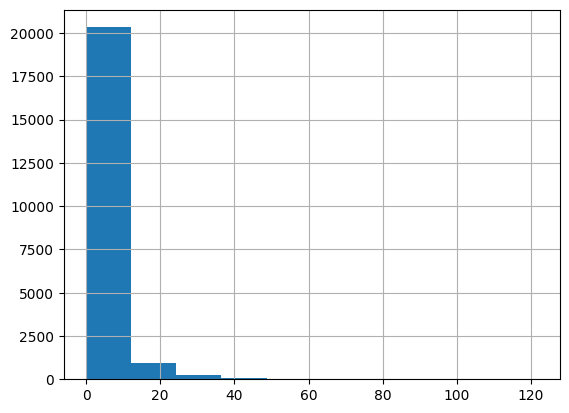

In [ ]:
value_counts = obs_2019['AWS'].value_counts()

print("Số lần xuất hiện nhiều nhất của 1 giá trị: ", value_counts.max())

# Tìm giá trị có số lần xuất hiện nhiều nhất
most_common_value = obs_2019['AWS'].value_counts().idxmax()

print("Giá trị có số lần xuất hiện nhiều nhất là:", most_common_value)

# Tìm giá trị lớn nhất trong cột 'Value'
min_value = obs_2019['AWS'].min()

print("Giá trị nhỏ nhất là:", min_value)

# Tìm giá trị lớn nhất trong cột 'Value'
max_value = obs_2019['AWS'].max()

print("Giá trị lớn nhất là:", max_value)

obs_2019['AWS'].hist()

In [ ]:
# Tạo file CSV từ dataframe result_df_all_months
obs_2019.to_csv('/content/obs_2019.csv', index=False)

#####Get Row and Column of OBS 2019 > 0

In [ ]:
# Tạo dataframe mới chỉ với các cột 'Row Position', 'Column Position', và 'name'
new_df = pd.DataFrame({
    'Row Position': obs_2019['Row Position'],
    'Column Position': obs_2019['Column Position'],
})

# Lọc ra dataframe mới với các giá trị (Row, Column) phân biệt
df_unique = new_df.drop_duplicates(subset=['Row Position', 'Column Position'])

# Hiển thị dataframe mới
print(df_unique)


       Row Position  Column Position
2409              7              115
2414             23              122
2413             21              109
2412             20              135
2411             16              109
...             ...              ...
16786            16              110
15686            55              114
11433             4               58
11146            49              111
20591            61              109

[311 rows x 2 columns]


#####Value = 0

In [ ]:
import os
import numpy as np
from osgeo import gdal
import pandas as pd

# Đường dẫn tới thư mục chứa các thư mục tháng
months_folder_path = "/content/data_folder/Data/precipitation/obs/2019"

# Hàm để đọc dữ liệu từ một thư mục tháng và tạo dataframe
def read_month_folder(month_folder, unique_df):
    month_folder_path = os.path.join(months_folder_path, month_folder)
    dfs = []
    for day_folder in os.listdir(month_folder_path):
        day_folder_path = os.path.join(month_folder_path, day_folder)
        if os.path.isdir(day_folder_path):
            for file in os.listdir(day_folder_path):
                if file.endswith(".tif"):
                    tif_file = os.path.join(day_folder_path, file)
                    ds = gdal.Open(tif_file)
                    myarray = np.array(ds.GetRasterBand(1).ReadAsArray())

                    # Lọc ra các giá trị có giá trị < 0.01
                    values = myarray[(myarray < 0.01)]
                    values = 0
                    row_indices, col_indices = np.where(myarray < 0.01)

                    # Tạo dataframe từ các giá trị đã lọc
                    data = {'AWS': values,
                            'Row Position': row_indices,
                            'Column Position': col_indices}
                    df = pd.DataFrame(data)
                    df['name'] = os.path.splitext(file)[0].replace("AWS_", "")

                    # Chỉ giữ lại các hàng và cột có trong df_unique
                    df = df[df[['Row Position', 'Column Position']].apply(tuple, axis=1).isin(unique_df.apply(tuple, axis=1))]

                    dfs.append(df)
    return pd.concat(dfs, ignore_index=True)


In [ ]:

# Đọc dữ liệu từ các thư mục tháng
dfs_all_months = []
for month_folder in os.listdir(months_folder_path):
    if os.path.isdir(os.path.join(months_folder_path, month_folder)):
        dfs_all_months.append(read_month_folder(month_folder, df_unique))

# Kết hợp các dataframe lại thành một dataframe duy nhất cho tất cả các tháng
obs_0_2019 = pd.concat(dfs_all_months, ignore_index=True)

# Hiển thị dataframe kết quả
print(obs_0_2019)

        AWS  Row Position  Column Position            name
0         0             0              114  20190406230000
1         0             0              116  20190406230000
2         0             0              118  20190406230000
3         0             0              119  20190406230000
4         0             0              120  20190406230000
...     ...           ...              ...             ...
397280    0            83              128  20191009100000
397281    0            84              124  20191009100000
397282    0            86              131  20191009100000
397283    0            87              132  20191009100000
397284    0            87              136  20191009100000

[397285 rows x 4 columns]


In [ ]:
import pandas as pd

# Lấy 18368 dòng ngẫu nhiên từ DataFrame ban đầu
obs_2019_0_choose = obs_0_2019.sample(n=18368, random_state=42)

# Sắp xếp lại DataFrame mới theo thứ tự
obs_2019_0_choose = obs_2019_0_choose.sort_index()

# Điều chỉnh lại chỉ số của DataFrame mới
obs_2019_0_choose.reset_index(drop=True, inplace=True)

In [ ]:
print(obs_2019_0_choose)

       AWS  Row Position  Column Position            name
0        0             2              117  20190406230000
1        0             8              103  20190406230000
2        0             8              111  20190406230000
3        0            13              110  20190406230000
4        0            16              109  20190406230000
...    ...           ...              ...             ...
18363    0            53              107  20191009100000
18364    0            54              102  20191009100000
18365    0            67              119  20191009100000
18366    0            72              114  20191009100000
18367    0            77              128  20191009100000

[18368 rows x 4 columns]


In [ ]:
# Tạo file CSV từ dataframe result_df_all_months
obs_2019_0_choose.to_csv('/content/obs_2019_0.csv', index=False)

#####Combine obs_2019_0 and obs_2019

In [ ]:
import pandas as pd

# Nối hai DataFrame thành một DataFrame mới
obs_combine_2019 = pd.concat([obs_2019, obs_2019_0_choose], ignore_index=True)

obs_combine_2019 = obs_combine_2019.sort_values(by='name')

# obs_combine_2019 = obs_combine_2019.rename(columns={'aws': 'AWS'})


# Điều chỉnh lại chỉ số của DataFrame mới
obs_combine_2019.reset_index(drop=True, inplace=True)

In [ ]:
print(obs_combine_2019)

        AWS  Row Position  Column Position            name
0      19.0             7              115  20190401000000
1       0.0            70              114  20190401000000
2       0.0            57              115  20190401000000
3       0.0            51               96  20190401000000
4       0.0            36              109  20190401000000
...     ...           ...              ...             ...
39995   1.0            12              119  20191031230000
39996   0.4            12              116  20191031230000
39997   0.2            11              124  20191031230000
39998   1.8             3              115  20191031230000
39999   0.6            23              101  20191031230000

[40000 rows x 4 columns]


Số lần xuất hiện nhiều nhất của 1 giá trị:  18368
Giá trị có số lần xuất hiện nhiều nhất là: 0.0
Giá trị nhỏ nhất là: 0.0
Giá trị lớn nhất là: 121.5999984741211


<Axes: >

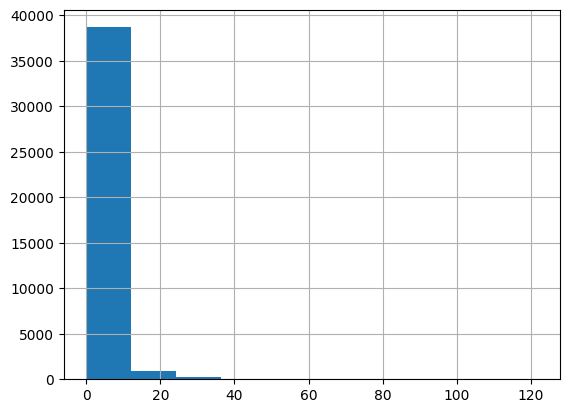

In [ ]:
value_counts = obs_combine_2019['AWS'].value_counts()

print("Số lần xuất hiện nhiều nhất của 1 giá trị: ", value_counts.max())

# Tìm giá trị có số lần xuất hiện nhiều nhất
most_common_value = obs_combine_2019['AWS'].value_counts().idxmax()

print("Giá trị có số lần xuất hiện nhiều nhất là:", most_common_value)

# Tìm giá trị lớn nhất trong cột 'Value'
min_value = obs_combine_2019['AWS'].min()

print("Giá trị nhỏ nhất là:", min_value)

# Tìm giá trị lớn nhất trong cột 'Value'
max_value = obs_combine_2019['AWS'].max()

print("Giá trị lớn nhất là:", max_value)

obs_combine_2019['AWS'].hist()

In [ ]:
# Tạo file CSV từ dataframe result_df_all_months
obs_combine_2019.to_csv('/content/obs_2019.csv', index=False)

####2020

#####Value > 0

In [ ]:
import os
import numpy as np
from osgeo import gdal
import pandas as pd

# Đường dẫn tới thư mục chứa các thư mục tháng
months_folder_path = "/content/data_folder/Data/precipitation/obs/2020"

# Hàm để đọc dữ liệu từ một thư mục tháng và tạo dataframe
def read_month_folder(month_folder):
    month_folder_path = os.path.join(months_folder_path, month_folder)
    dfs = []
    for day_folder in os.listdir(month_folder_path):
        day_folder_path = os.path.join(month_folder_path, day_folder)
        if os.path.isdir(day_folder_path):
            for file in os.listdir(day_folder_path):
                if file.endswith(".tif"):
                    tif_file = os.path.join(day_folder_path, file)
                    ds = gdal.Open(tif_file)
                    myarray = np.array(ds.GetRasterBand(1).ReadAsArray())
                    values = myarray[(myarray > 0)]
                    row_indices, col_indices = np.where(myarray > 0)
                    data = {'AWS': values,
                            'Row Position': row_indices,
                            'Column Position': col_indices}
                    df = pd.DataFrame(data)
                    df['name'] = os.path.splitext(file)[0].replace("AWS_", "")
                    dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

In [ ]:
# Tạo dataframe tổng hợp từ tất cả các thư mục tháng
dfs_all_months = []
for month_folder in os.listdir(months_folder_path):
    if os.path.isdir(os.path.join(months_folder_path, month_folder)):
        dfs_all_months.append(read_month_folder(month_folder))

# Kết hợp các dataframe lại thành một dataframe duy nhất cho tất cả các tháng
result_df_all_months = pd.concat(dfs_all_months, ignore_index=True)

# Sắp xếp lại theo cột 'name' theo giá trị tăng dần
obs_2020 = result_df_all_months.sort_values(by='name')

# Hiển thị dataframe kết quả
print(obs_2020)

        AWS  Row Position  Column Position            name
5722   0.20            60              107  20200401000000
5723   0.20            61              109  20200401000000
5724   0.20            63              109  20200401000000
5725   0.40            65              114  20200401000000
5726   0.20            72              114  20200401000000
...     ...           ...              ...             ...
16455  0.80            84              137  20201031230000
16456  2.20            86              131  20201031230000
16457  0.70            87              132  20201031230000
16440  0.05             8               88  20201031230000
16443  0.20            58              105  20201031230000

[64125 rows x 4 columns]


Số lần xuất hiện nhiều nhất của 1 giá trị:  15065
Giá trị có số lần xuất hiện nhiều nhất là: 0.2
Giá trị nhỏ nhất là: 0.01
Giá trị lớn nhất là: 107.4


<Axes: >

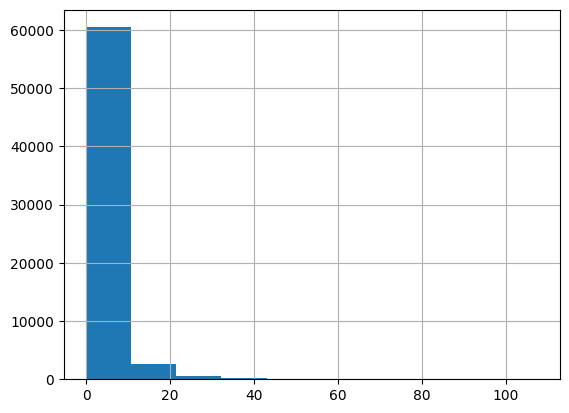

In [ ]:
value_counts = obs_2020['AWS'].value_counts()

print("Số lần xuất hiện nhiều nhất của 1 giá trị: ", value_counts.max())

# Tìm giá trị có số lần xuất hiện nhiều nhất
most_common_value = obs_2020['AWS'].value_counts().idxmax()

print("Giá trị có số lần xuất hiện nhiều nhất là:", most_common_value)

# Tìm giá trị lớn nhất trong cột 'Value'
min_value = obs_2020['AWS'].min()

print("Giá trị nhỏ nhất là:", min_value)

# Tìm giá trị lớn nhất trong cột 'Value'
max_value = obs_2020['AWS'].max()

print("Giá trị lớn nhất là:", max_value)

obs_2020['AWS'].hist()

In [ ]:
# Tạo file CSV từ dataframe result_df_all_years
obs_2020.to_csv('/content/obs_2020larger0.csv', index=False)

#####Get Row and Col of OBS > 0 in 2020

In [ ]:
# Tạo dataframe mới chỉ với các cột 'Row Position', 'Column Position', và 'name'
new_df = pd.DataFrame({
    'Row Position': obs_2020['Row Position'],
    'Column Position': obs_2020['Column Position'],
})

# Lọc ra dataframe mới với các giá trị (Row, Column) phân biệt
df_unique = new_df.drop_duplicates(subset=['Row Position', 'Column Position'])

# Hiển thị dataframe mới
print(df_unique)


       Row Position  Column Position
5722             60              107
5723             61              109
5724             63              109
5725             65              114
5726             72              114
...             ...              ...
43158            78              130
42268            57              115
53652            16              110
33351            13              107
46506             7              138

[325 rows x 2 columns]


#####value = 0

In [ ]:
import os
import numpy as np
from osgeo import gdal
import pandas as pd

# Đường dẫn tới thư mục chứa các thư mục tháng
months_folder_path = "/content/data_folder/Data/precipitation/obs/2020"

# Hàm để đọc dữ liệu từ một thư mục tháng và tạo dataframe
def read_month_folder(month_folder, unique_df):
    month_folder_path = os.path.join(months_folder_path, month_folder)
    dfs = []
    for day_folder in os.listdir(month_folder_path):
        day_folder_path = os.path.join(month_folder_path, day_folder)
        if os.path.isdir(day_folder_path):
            for file in os.listdir(day_folder_path):
                if file.endswith(".tif"):
                    tif_file = os.path.join(day_folder_path, file)
                    ds = gdal.Open(tif_file)
                    myarray = np.array(ds.GetRasterBand(1).ReadAsArray())

                    # Lọc ra các giá trị có giá trị < 0.01
                    values = myarray[(myarray < 0.01)]
                    values = 0
                    row_indices, col_indices = np.where(myarray < 0.01)

                    # Tạo dataframe từ các giá trị đã lọc
                    data = {'AWS': values,
                            'Row Position': row_indices,
                            'Column Position': col_indices}
                    df = pd.DataFrame(data)
                    df['name'] = os.path.splitext(file)[0].replace("AWS_", "")

                    # Chỉ giữ lại các hàng và cột có trong df_unique
                    df = df[df[['Row Position', 'Column Position']].apply(tuple, axis=1).isin(unique_df.apply(tuple, axis=1))]

                    dfs.append(df)
    return pd.concat(dfs, ignore_index=True)


In [ ]:

# Đọc dữ liệu từ các thư mục tháng
dfs_all_months = []
for month_folder in os.listdir(months_folder_path):
    if os.path.isdir(os.path.join(months_folder_path, month_folder)):
        dfs_all_months.append(read_month_folder(month_folder, df_unique))

# Kết hợp các dataframe lại thành một dataframe duy nhất cho tất cả các tháng
obs_2020_0 = pd.concat(dfs_all_months, ignore_index=True)

# Hiển thị dataframe kết quả
print(obs_2020_0)

        AWS  Row Position  Column Position            name
0         0             0              104  20200406090000
1         0             0              106  20200406090000
2         0             0              114  20200406090000
3         0             0              116  20200406090000
4         0             0              118  20200406090000
...     ...           ...              ...             ...
410370    0            76              130  20201009000000
410371    0            76              134  20201009000000
410372    0            77              131  20201009000000
410373    0            78              130  20201009000000
410374    0            83              135  20201009000000

[410375 rows x 4 columns]


In [ ]:
import pandas as pd

# Lấy 35875 dòng ngẫu nhiên từ DataFrame ban đầu
obs_2020_0_choose = obs_2020_0.sample(n=35875, random_state=42)

# Sắp xếp lại DataFrame mới theo thứ tự
obs_2020_0_choose = obs_2020_0_choose.sort_index()

# Điều chỉnh lại chỉ số của DataFrame mới
obs_2020_0_choose.reset_index(drop=True, inplace=True)

In [ ]:
print(obs_2020_0_choose)

       AWS  Row Position  Column Position            name
0        0             0              237  20200423070000
1        0             1               43  20200423070000
2        0             1              138  20200423070000
3        0             3              194  20200423070000
4        0            12               83  20200423070000
...    ...           ...              ...             ...
35870    0            74               26  20201010220000
35871    0            77               18  20201010220000
35872    0            78              147  20201010220000
35873    0            84              241  20201010220000
35874    0            88              242  20201010220000

[35875 rows x 4 columns]


#####combine 2020 and 2020_0

In [ ]:
import pandas as pd

# Nối hai DataFrame thành một DataFrame mới
obs_combine_2020 = pd.concat([obs_2020, obs_2020_0_choose], ignore_index=True)

obs_combine_2020 = obs_combine_2020.sort_values(by='name')

# Điều chỉnh lại chỉ số của DataFrame mới
obs_combine_2020.reset_index(drop=True, inplace=True)

print(obs_combine_2020)

       AWS  Row Position  Column Position            name
0      0.2            60              107  20200401000000
1      0.0            60              112  20200401000000
2      0.0            51              101  20200401000000
3      0.0            51               93  20200401000000
4      0.0            50              108  20200401000000
...    ...           ...              ...             ...
99995  0.0             6               86  20201031230000
99996  0.0             8              111  20201031230000
99997  0.0             9              108  20201031230000
99998  0.0            32              105  20201031230000
99999  0.0            12              119  20201031230000

[100000 rows x 4 columns]


###2 year

In [ ]:
import os
import numpy as np
from osgeo import gdal
import pandas as pd

# Đường dẫn tới thư mục chứa các thư mục năm
years_folder_path = "/content/data_folder/Data/precipitation/obs/"

# Hàm để đọc dữ liệu từ một thư mục năm và tạo dataframe
def read_year_folder(year_folder):
    year_folder_path = os.path.join(years_folder_path, year_folder)
    dfs = []
    for month_folder in os.listdir(year_folder_path):
        month_folder_path = os.path.join(year_folder_path, month_folder)
        if os.path.isdir(month_folder_path):
            for day_folder in os.listdir(month_folder_path):
                day_folder_path = os.path.join(month_folder_path, day_folder)
                if os.path.isdir(day_folder_path):
                    for file in os.listdir(day_folder_path):
                        if file.endswith(".tif"):
                            tif_file = os.path.join(day_folder_path, file)
                            ds = gdal.Open(tif_file)
                            myarray = np.array(ds.GetRasterBand(1).ReadAsArray())
                            values = myarray[(myarray > 0)]
                            row_indices, col_indices = np.where(myarray > 0)
                            data = {'AWS': values,
                                    'Row Position': row_indices,
                                    'Column Position': col_indices}
                            df = pd.DataFrame(data)
                            df['name'] = os.path.splitext(file)[0].replace("AWS_", "")
                            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# Tạo dataframe tổng hợp từ tất cả các thư mục năm
dfs_all_years = []
for year_folder in os.listdir(years_folder_path):
    if os.path.isdir(os.path.join(years_folder_path, year_folder)):
        dfs_all_years.append(read_year_folder(year_folder))

# Kết hợp các dataframe lại thành một dataframe duy nhất cho tất cả các năm
obs_all_years = pd.concat(dfs_all_years, ignore_index=True)

# Sắp xếp lại theo cột 'name' theo giá trị tăng dần
obs_all_years = obs_all_years.sort_values(by='name')

# Hiển thị dataframe kết quả
print(obs_all_years)


        AWS  Row Position  Column Position            name
3687    0.2            38               96  20190401000000
3676    0.2             3              115  20190401000000
3677    0.8             5              114  20190401000000
3678    0.6             6              116  20190401000000
3679   19.0             7              115  20190401000000
...     ...           ...              ...             ...
44978   0.7            87              132  20201031230000
44979   3.0            87              136  20201031230000
44971   0.2            82              119  20201031230000
44967   0.1            66              107  20201031230000
44972   0.4            82              127  20201031230000

[85757 rows x 4 columns]


Số lần xuất hiện nhiều nhất của 1 giá trị:  21379
Giá trị có số lần xuất hiện nhiều nhất là: 0.2
Giá trị lớn nhất là: 121.6


<Axes: >

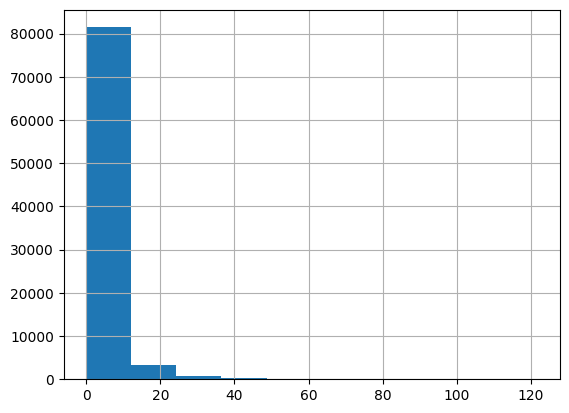

In [ ]:
value_counts = obs_all_years['AWS'].value_counts()

print("Số lần xuất hiện nhiều nhất của 1 giá trị: ", value_counts.max())

# Tìm giá trị có số lần xuất hiện nhiều nhất
most_common_value = obs_all_years['AWS'].value_counts().idxmax()

print("Giá trị có số lần xuất hiện nhiều nhất là:", most_common_value)

# Tìm giá trị lớn nhất trong cột 'Value'
max_value = obs_all_years['AWS'].max()

print("Giá trị lớn nhất là:", max_value)

obs_all_years['AWS'].hist()

<Axes: >

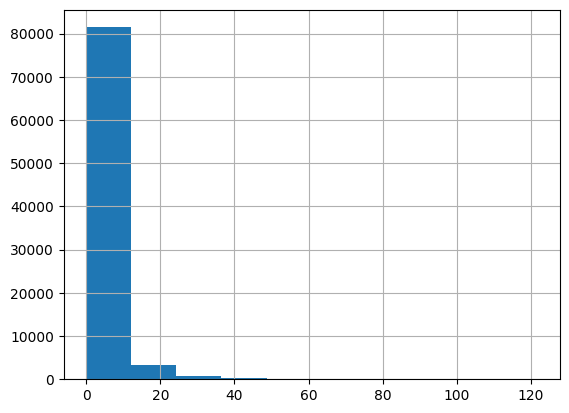

In [ ]:
obs_all_years['AWS'].hist()

In [ ]:
# Tạo file CSV từ dataframe result_df_all_years
# obs_all_years.to_csv('/content/obs.csv', index=False)

##Imerg

###1 month

In [ ]:
import os
import numpy as np
from osgeo import gdal
import pandas as pd

# Hàm để đọc dữ liệu từ một thư mục ngày và tạo dataframe
def read_day_folder(day_folder):
    day_folder_path = os.path.join(month_folder_path, day_folder)
    dfs = []
    for file in os.listdir(day_folder_path):
        if file.endswith(".tif"):
            tif_file = os.path.join(day_folder_path, file)
            ds = gdal.Open(tif_file)
            myarray = np.array(ds.GetRasterBand(1).ReadAsArray())
            values = myarray[(myarray > 0)]
            row_indices, col_indices = np.where(myarray > 0)
            data = {'Value': values,
                    'Row Position': row_indices,
                    'Column Position': col_indices}
            df = pd.DataFrame(data)
            df['name'] = os.path.splitext(file)[0].replace("IMERG_E_", "")
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

In [ ]:
# Tạo dataframe tổng hợp từ tất cả các thư mục ngày trong thư mục của tháng
dfs_month = []
# Đường dẫn tới thư mục chứa các thư mục ngày
month_folder_path = "/content/data_folder/Data/precipitation/imerg/2020/10"
for day_folder in os.listdir(month_folder_path):
    if os.path.isdir(os.path.join(month_folder_path, day_folder)):
        dfs_month.append(read_day_folder(day_folder))

# Kết hợp các dataframe lại thành một dataframe duy nhất cho cả tháng
result_df_month = pd.concat(dfs_month, ignore_index=True)

# Sắp xếp lại theo cột 'name' theo giá trị tăng dần
result_df_month = result_df_month.sort_values(by='name')

# Đổi tên cột 'Value' thành 'aws'
imerg_df_month = result_df_month.rename(columns={'Value': 'Imerg'})

# Hiển thị dataframe kết quả
print(imerg_df_month)

# Tạo file CSV từ dataframe result_df_month
#result_df_month.to_csv('/content/result_df_month.csv', index=False)


         Imerg  Row Position  Column Position            name
4005542   0.82             6              173  20201001000000
4005384   0.01             4              213  20201001000000
4005385   0.01             4              214  20201001000000
4005386   1.32             4              222  20201001000000
4005387   1.32             4              223  20201001000000
...        ...           ...              ...             ...
1795109   0.02             8              218  20201031230000
1795110   0.02             8              219  20201031230000
1795111   0.02             8              220  20201031230000
1795102   0.02             7              220  20201031230000
1795231   0.02            70              170  20201031230000

[5993177 rows x 4 columns]


Số lần xuất hiện nhiều nhất của 1 giá trị:  51330
Giá trị có số lần xuất hiện nhiều nhất là: 0.02
Giá trị lớn nhất là: 169.62


<Axes: >

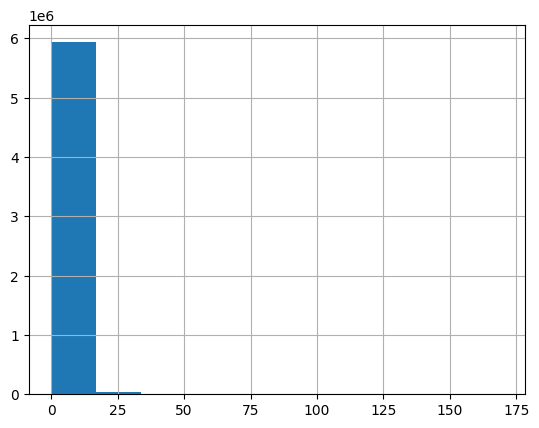

In [ ]:
value_counts = imerg_df_month['Imerg'].value_counts()

print("Số lần xuất hiện nhiều nhất của 1 giá trị: ", value_counts.max())

# Tìm giá trị có số lần xuất hiện nhiều nhất
most_common_value = imerg_df_month['Imerg'].value_counts().idxmax()

print("Giá trị có số lần xuất hiện nhiều nhất là:", most_common_value)

# Tìm giá trị lớn nhất trong cột 'Value'
max_value = imerg_df_month['Imerg'].max()

print("Giá trị lớn nhất là:", max_value)

imerg_df_month['Imerg'].hist()

###2 years

In [ ]:
import os
import numpy as np
from osgeo import gdal
import pandas as pd

# Đường dẫn tới thư mục chứa các thư mục năm
years_folder_path = "/content/data_folder/Data/precipitation/imerg"

# Hàm để đọc dữ liệu từ một thư mục năm và tạo dataframe
def read_year_folder(year_folder):
    year_folder_path = os.path.join(years_folder_path, year_folder)
    dfs = []
    for month_folder in os.listdir(year_folder_path):
        month_folder_path = os.path.join(year_folder_path, month_folder)
        if os.path.isdir(month_folder_path):
            for day_folder in os.listdir(month_folder_path):
                day_folder_path = os.path.join(month_folder_path, day_folder)
                if os.path.isdir(day_folder_path):
                    for file in os.listdir(day_folder_path):
                        if file.endswith(".tif"):
                            tif_file = os.path.join(day_folder_path, file)
                            ds = gdal.Open(tif_file)
                            myarray = np.array(ds.GetRasterBand(1).ReadAsArray())
                            values = myarray[(myarray > 0)]
                            row_indices, col_indices = np.where(myarray > 0)
                            data = {'Imerg': values,
                                    'Row Position': row_indices,
                                    'Column Position': col_indices}
                            df = pd.DataFrame(data)
                            df['name'] = os.path.splitext(file)[0].replace("IMERG_E_", "")
                            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# Tạo dataframe tổng hợp từ tất cả các thư mục năm
dfs_all_years = []
for year_folder in os.listdir(years_folder_path):
    if os.path.isdir(os.path.join(years_folder_path, year_folder)):
        dfs_all_years.append(read_year_folder(year_folder))

# Kết hợp các dataframe lại thành một dataframe duy nhất cho tất cả các năm
imerg_all_years = pd.concat(dfs_all_years, ignore_index=True)

# Sắp xếp lại theo cột 'name' theo giá trị tăng dần
imerg_all_years = imerg_all_years.sort_values(by='name')

# Hiển thị dataframe kết quả
print(imerg_all_years)


             Imerg  Row Position  Column Position            name
841943   13.960344            13              235  20190401000000
843042    0.030000            50               65  20190401000000
843043    0.030000            50               66  20190401000000
843044    0.030000            50               67  20190401000000
843045    0.030000            50               68  20190401000000
...            ...           ...              ...             ...
8085701   0.040000            20              137  20201031230000
8085700   0.060000            20              136  20201031230000
8085699   0.060000            20              135  20201031230000
8085708   0.040000            21              137  20201031230000
8085579   0.160000             0                6  20201031230000

[12283708 rows x 4 columns]


Số lần xuất hiện nhiều nhất của 1 giá trị:  130736
Giá trị có số lần xuất hiện nhiều nhất là: 0.02
Giá trị nhỏ nhất là: 4.2237613e-16
Giá trị lớn nhất là: 182.94


<Axes: >

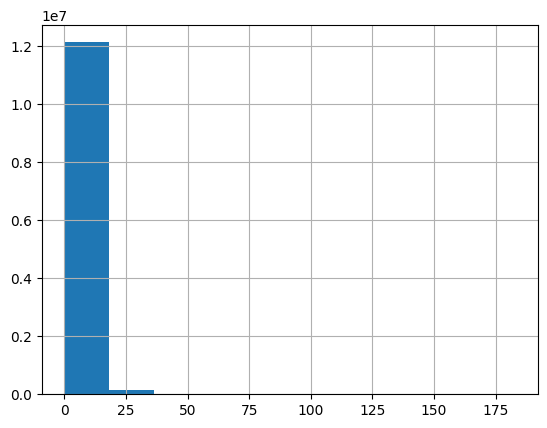

In [ ]:
value_counts = imerg_all_years['Imerg'].value_counts()
print( "Số lần xuất hiện nhiều nhất của 1 giá trị: ", value_counts.max())

# Tìm giá trị có số lần xuất hiện nhiều nhất
most_common_value = imerg_all_years['Imerg'].value_counts().idxmax()

print("Giá trị có số lần xuất hiện nhiều nhất là:", most_common_value)

# Tìm giá trị nhỏ nhất trong cột 'Value'
min_value = imerg_all_years['Imerg'].min()

print("Giá trị nhỏ nhất là:", min_value)

# Tìm giá trị lớn nhất trong cột 'Value'
max_value = imerg_all_years['Imerg'].max()

print("Giá trị lớn nhất là:", max_value)

imerg_all_years['Imerg'].hist()


<Axes: >

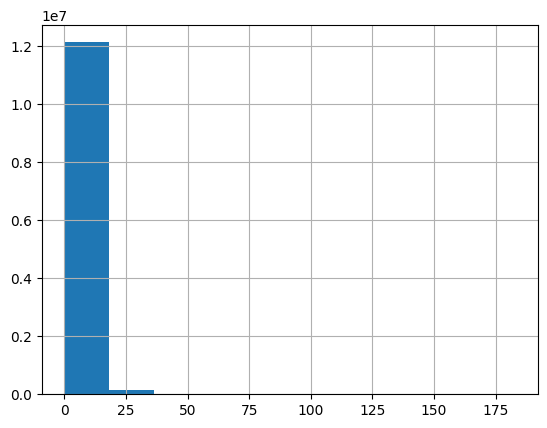

In [ ]:
imerg_all_years['Imerg'].hist()

In [ ]:
# Tạo file CSV từ dataframe result_df_all_years
# imerg_all_years.to_csv('/content/imerg_df_all_years.csv', index=False)

##Era5

###R500

In [ ]:
import os
import numpy as np
from osgeo import gdal
import pandas as pd

# Đường dẫn tới thư mục chứa các thư mục năm
years_folder_path = "/content/data_folder/Data/era5/R500"

# Hàm để đọc dữ liệu từ một thư mục năm và tạo dataframe
def read_year_folder(year_folder):
    year_folder_path = os.path.join(years_folder_path, year_folder)
    dfs = []
    for month_folder in os.listdir(year_folder_path):
        month_folder_path = os.path.join(year_folder_path, month_folder)
        if os.path.isdir(month_folder_path):
            for day_folder in os.listdir(month_folder_path):
                day_folder_path = os.path.join(month_folder_path, day_folder)
                if os.path.isdir(day_folder_path):
                    for file in os.listdir(day_folder_path):
                        if file.endswith(".tif"):
                            tif_file = os.path.join(day_folder_path, file)
                            ds = gdal.Open(tif_file)
                            myarray = np.array(ds.GetRasterBand(1).ReadAsArray())
                            values = myarray[(myarray > 0)]
                            row_indices, col_indices = np.where(myarray > 0)
                            data = {'R500': values,
                                    'Row Position': row_indices,
                                    'Column Position': col_indices}
                            df = pd.DataFrame(data)
                            df['name'] = os.path.splitext(file)[0].replace("R500_", "")
                            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# Tạo dataframe tổng hợp từ tất cả các thư mục năm
dfs_all_years = []
for year_folder in os.listdir(years_folder_path):
    if os.path.isdir(os.path.join(years_folder_path, year_folder)):
        dfs_all_years.append(read_year_folder(year_folder))

# Kết hợp các dataframe lại thành một dataframe duy nhất cho tất cả các năm
r500_all_years = pd.concat(dfs_all_years, ignore_index=True)

# Sắp xếp lại theo cột 'name' theo giá trị tăng dần
r500_all_years = r500_all_years.sort_values(by='name')

# Hiển thị dataframe kết quả
print(r500_all_years)



               R500  Row Position  Column Position            name
65328325   1.119702            44              228  20190401000000
65332102   3.385327            60                5  20190401000000
65332101   3.385327            60                4  20190401000000
65332100   3.385327            60                3  20190401000000
65332099   3.256421            60                2  20190401000000
...             ...           ...              ...             ...
195004    46.381592            60                4  20201031230000
195005    46.381592            60                5  20201031230000
195006    46.381592            60                6  20201031230000
194998    54.018311            59              248  20201031230000
180001    59.893311             0                1  20201031230000

[65879597 rows x 4 columns]


In [ ]:
# Tạo file CSV từ dataframe result_df_all_years
r500_all_years.to_csv('/content/r500_all_years.csv', index=False)

###R850

In [ ]:
import os
import numpy as np
from osgeo import gdal
import pandas as pd

# Đường dẫn tới thư mục chứa các thư mục năm
years_folder_path = "/content/data_folder/Data/era5/R850"

# Hàm để đọc dữ liệu từ một thư mục năm và tạo dataframe
def read_year_folder(year_folder):
    year_folder_path = os.path.join(years_folder_path, year_folder)
    dfs = []
    for month_folder in os.listdir(year_folder_path):
        month_folder_path = os.path.join(year_folder_path, month_folder)
        if os.path.isdir(month_folder_path):
            for day_folder in os.listdir(month_folder_path):
                day_folder_path = os.path.join(month_folder_path, day_folder)
                if os.path.isdir(day_folder_path):
                    for file in os.listdir(day_folder_path):
                        if file.endswith(".tif"):
                            tif_file = os.path.join(day_folder_path, file)
                            ds = gdal.Open(tif_file)
                            myarray = np.array(ds.GetRasterBand(1).ReadAsArray())
                            values = myarray[(myarray > 0)]
                            row_indices, col_indices = np.where(myarray > 0)
                            data = {'R850': values,
                                    'Row Position': row_indices,
                                    'Column Position': col_indices}
                            df = pd.DataFrame(data)
                            df['name'] = os.path.splitext(file)[0].replace("R850_", "")
                            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# Tạo dataframe tổng hợp từ tất cả các thư mục năm
dfs_all_years = []
for year_folder in os.listdir(years_folder_path):
    if os.path.isdir(os.path.join(years_folder_path, year_folder)):
        dfs_all_years.append(read_year_folder(year_folder))

# Kết hợp các dataframe lại thành một dataframe duy nhất cho tất cả các năm
r850_all_years = pd.concat(dfs_all_years, ignore_index=True)

# Sắp xếp lại theo cột 'name' theo giá trị tăng dần
r850_all_years = r850_all_years.sort_values(by='name')

# Hiển thị dataframe kết quả
print(r850_all_years)


               R850  Row Position  Column Position            name
65204997  73.823593            89              247  20190401000000
65189992  95.921249            29              242  20190401000000
65189993  95.921249            29              243  20190401000000
65189994  95.921249            29              244  20190401000000
65189995  95.921249            29              245  20190401000000
...             ...           ...              ...             ...
322498    28.785812            29              248  20201031230000
322497    28.785812            29              247  20201031230000
322496    42.520187            29              246  20201031230000
322504    85.828781            30                4  20201031230000
326251    90.610031            45                1  20201031230000

[65880000 rows x 4 columns]


In [ ]:
# Tạo file CSV từ dataframe result_df_all_years
r850_all_years.to_csv('/content/r850_all_years.csv', index=False)

###SLHF

In [ ]:
import os
import numpy as np
from osgeo import gdal
import pandas as pd

# Đường dẫn tới thư mục chứa các thư mục năm
years_folder_path = "/content/data_folder/Data/era5/SLHF"

# Hàm để đọc dữ liệu từ một thư mục năm và tạo dataframe
def read_year_folder(year_folder):
    year_folder_path = os.path.join(years_folder_path, year_folder)
    dfs = []
    for month_folder in os.listdir(year_folder_path):
        month_folder_path = os.path.join(year_folder_path, month_folder)
        if os.path.isdir(month_folder_path):
            for day_folder in os.listdir(month_folder_path):
                day_folder_path = os.path.join(month_folder_path, day_folder)
                if os.path.isdir(day_folder_path):
                    for file in os.listdir(day_folder_path):
                        if file.endswith(".tif"):
                            tif_file = os.path.join(day_folder_path, file)
                            ds = gdal.Open(tif_file)
                            myarray = np.array(ds.GetRasterBand(1).ReadAsArray())
                            values = myarray[(myarray > 0)]
                            row_indices, col_indices = np.where(myarray > 0)
                            data = {'SLHF': values,
                                    'Row Position': row_indices,
                                    'Column Position': col_indices}
                            df = pd.DataFrame(data)
                            df['name'] = os.path.splitext(file)[0].replace("SLHF_", "")
                            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# Tạo dataframe tổng hợp từ tất cả các thư mục năm
dfs_all_years = []
for year_folder in os.listdir(years_folder_path):
    if os.path.isdir(os.path.join(years_folder_path, year_folder)):
        dfs_all_years.append(read_year_folder(year_folder))

# Kết hợp các dataframe lại thành một dataframe duy nhất cho tất cả các năm
slhf_all_years = pd.concat(dfs_all_years, ignore_index=True)

# Sắp xếp lại theo cột 'name' theo giá trị tăng dần
slhf_all_years = slhf_all_years.sort_values(by='name')

# Hiển thị dataframe kết quả
print(slhf_all_years)


            SLHF  Row Position  Column Position            name
3123322  11609.0            64              132  20190401000000
3123197   9241.0            48               55  20190401000000
3123196   9241.0            48               54  20190401000000
3123195   9241.0            48               53  20190401000000
3123194  19353.0            48               52  20190401000000
...          ...           ...              ...             ...
39032     1801.0            19               30  20201031230000
39031     1801.0            19               29  20201031230000
39030     1801.0            19               28  20201031230000
39094     7369.0            19              104  20201031230000
39997     5769.0            28              101  20201031230000

[3201014 rows x 4 columns]


###TCLW

In [ ]:
import os
import numpy as np
from osgeo import gdal
import pandas as pd

# Đường dẫn tới thư mục chứa các thư mục năm
years_folder_path = "/content/data_folder/Data/era5/TCLW"

# Hàm để đọc dữ liệu từ một thư mục năm và tạo dataframe
def read_year_folder(year_folder):
    year_folder_path = os.path.join(years_folder_path, year_folder)
    dfs = []
    for month_folder in os.listdir(year_folder_path):
        month_folder_path = os.path.join(year_folder_path, month_folder)
        if os.path.isdir(month_folder_path):
            for day_folder in os.listdir(month_folder_path):
                day_folder_path = os.path.join(month_folder_path, day_folder)
                if os.path.isdir(day_folder_path):
                    for file in os.listdir(day_folder_path):
                        if file.endswith(".tif"):
                            tif_file = os.path.join(day_folder_path, file)
                            ds = gdal.Open(tif_file)
                            myarray = np.array(ds.GetRasterBand(1).ReadAsArray())
                            values = myarray[(myarray > 0)]
                            row_indices, col_indices = np.where(myarray > 0)
                            data = {'TCLW': values,
                                    'Row Position': row_indices,
                                    'Column Position': col_indices}
                            df = pd.DataFrame(data)
                            df['name'] = os.path.splitext(file)[0].replace("TCLW_", "")
                            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# Tạo dataframe tổng hợp từ tất cả các thư mục năm
dfs_all_years = []
for year_folder in os.listdir(years_folder_path):
    if os.path.isdir(os.path.join(years_folder_path, year_folder)):
        dfs_all_years.append(read_year_folder(year_folder))

# Kết hợp các dataframe lại thành một dataframe duy nhất cho tất cả các năm
tclw_all_years = pd.concat(dfs_all_years, ignore_index=True)

# Sắp xếp lại theo cột 'name' theo giá trị tăng dần
tclw_all_years = tclw_all_years.sort_values(by='name')

# Hiển thị dataframe kết quả
print(tclw_all_years)


###TCWV

In [ ]:
import os
import numpy as np
from osgeo import gdal
import pandas as pd

# Đường dẫn tới thư mục chứa các thư mục năm
years_folder_path = "/content/data_folder/Data/era5/TCWV"

# Hàm để đọc dữ liệu từ một thư mục năm và tạo dataframe
def read_year_folder(year_folder):
    year_folder_path = os.path.join(years_folder_path, year_folder)
    dfs = []
    for month_folder in os.listdir(year_folder_path):
        month_folder_path = os.path.join(year_folder_path, month_folder)
        if os.path.isdir(month_folder_path):
            for day_folder in os.listdir(month_folder_path):
                day_folder_path = os.path.join(month_folder_path, day_folder)
                if os.path.isdir(day_folder_path):
                    for file in os.listdir(day_folder_path):
                        if file.endswith(".tif"):
                            tif_file = os.path.join(day_folder_path, file)
                            ds = gdal.Open(tif_file)
                            myarray = np.array(ds.GetRasterBand(1).ReadAsArray())
                            values = myarray[(myarray > 0)]
                            row_indices, col_indices = np.where(myarray > 0)
                            data = {'TCWV': values,
                                    'Row Position': row_indices,
                                    'Column Position': col_indices}
                            df = pd.DataFrame(data)
                            df['name'] = os.path.splitext(file)[0].replace("TCWV_", "")
                            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# Tạo dataframe tổng hợp từ tất cả các thư mục năm
dfs_all_years = []
for year_folder in os.listdir(years_folder_path):
    if os.path.isdir(os.path.join(years_folder_path, year_folder)):
        dfs_all_years.append(read_year_folder(year_folder))

# Kết hợp các dataframe lại thành một dataframe duy nhất cho tất cả các năm
tcwv_all_years = pd.concat(dfs_all_years, ignore_index=True)

# Sắp xếp lại theo cột 'name' theo giá trị tăng dần
tcwv_all_years = tcwv_all_years.sort_values(by='name')

# Hiển thị dataframe kết quả
print(tcwv_all_years)


##DEM

In [ ]:
import numpy as np
from osgeo import gdal
ds = gdal.Open("/content/data_folder/Data/DEM_BTB.tif")
dem = np.array(ds.GetRasterBand(1).ReadAsArray())


In [ ]:
import pandas as pd
import numpy as np

# Giả sử arr là NumPy array của bạn

# Tạo các mảng tương ứng với hàng và cột
row_positions, column_positions = np.indices(dem.shape)

# Tạo DataFrame từ các mảng này và giá trị DEM từ arr
dem_df = pd.DataFrame({
    'Row Position': row_positions.flatten(),
    'Column Position': column_positions.flatten(),
    'DEM': dem.flatten()
})

In [ ]:
print(dem_df)

       Row Position  Column Position    DEM
0                 0                0    925
1                 0                1    853
2                 0                2    948
3                 0                3   1312
4                 0                4   1456
...             ...              ...    ...
22495            89              245  32767
22496            89              246  32767
22497            89              247  32767
22498            89              248  32767
22499            89              249  32767

[22500 rows x 3 columns]


In [ ]:
obs_copy = obs_combine_2020.copy()
obs_merge_dem = obs_copy.merge(dem_df, on=['Row Position', 'Column Position'], how='left', suffixes=('', '_dem'))


In [ ]:
print(obs_merge_dem)

       AWS  Row Position  Column Position            name   DEM
0      0.2            60              107  20200401000000    69
1      0.0            60              112  20200401000000    25
2      0.0            51              101  20200401000000    44
3      0.0            51               93  20200401000000   270
4      0.0            50              108  20200401000000   241
...    ...           ...              ...             ...   ...
99995  0.0             6               86  20201031230000  1013
99996  0.0             8              111  20201031230000   120
99997  0.0             9              108  20201031230000   226
99998  0.0            32              105  20201031230000   126
99999  0.0            12              119  20201031230000    20

[100000 rows x 5 columns]


#Sol 2: create dataframe

**Only get cells with value > 0 in obs**

### Get Col, Row and name

In [ ]:
# Tạo dataframe mới chỉ với các cột 'Row Position', 'Column Position', và 'name'
new_df = pd.DataFrame({
    'Row Position': obs_merge_dem['Row Position'],
    'Column Position': obs_merge_dem['Column Position'],
    'name': obs_merge_dem['name']
})

# Hiển thị dataframe mới
print(new_df)


       Row Position  Column Position            name
0                60              107  20200401000000
1                60              112  20200401000000
2                51              101  20200401000000
3                51               93  20200401000000
4                50              108  20200401000000
...             ...              ...             ...
99995             6               86  20201031230000
99996             8              111  20201031230000
99997             9              108  20201031230000
99998            32              105  20201031230000
99999            12              119  20201031230000

[100000 rows x 3 columns]


###Imerg

In [ ]:
import os
import numpy as np
from osgeo import gdal
import pandas as pd

# Đường dẫn tới thư mục Imerg
imerg_folder_path = "/content/data_folder/Data/precipitation/imerg/2020"

# Hàm để trích xuất giá trị từ tệp Imerg
def extract_imerg_value(file_path, row_pos, col_pos):
    ds = gdal.Open(file_path)
    myarray = np.array(ds.GetRasterBand(1).ReadAsArray())
    return myarray[row_pos, col_pos]

# Tạo danh sách các DataFrame
dfs = []

# Duyệt qua từng hàng trong dataframe new_df
for index, row in new_df.iterrows():
    name = row['name']
    row_pos = row['Row Position']
    col_pos = row['Column Position']
    month = name[4:6]
    day = name[6:8]
    imerg_file_name = f"IMERG_E_{name}.tif"
    imerg_file_path = os.path.join(imerg_folder_path, month, day, imerg_file_name)
    if os.path.exists(imerg_file_path):
        imerg_value = extract_imerg_value(imerg_file_path, row_pos, col_pos)
        dfs.append(pd.DataFrame({'Row Position': [row_pos], 'Column Position': [col_pos], 'name': [name], 'Imerg': [imerg_value]}))

# Kết hợp danh sách các DataFrame thành một DataFrame lớn
imerg_new_df = pd.concat(dfs, ignore_index=True)

# Hiển thị dataframe mới
print(imerg_new_df)


       Row Position  Column Position            name  Imerg
0                60              107  20200401000000    0.0
1                60              112  20200401000000    0.0
2                51              101  20200401000000    0.0
3                51               93  20200401000000    0.0
4                50              108  20200401000000    0.0
...             ...              ...             ...    ...
99995             6               86  20201031230000    0.0
99996             8              111  20201031230000    0.0
99997             9              108  20201031230000    0.0
99998            32              105  20201031230000    0.0
99999            12              119  20201031230000    0.0

[100000 rows x 4 columns]


In [ ]:
# Tạo file CSV từ dataframe result_df_all_years
imerg_new_df.to_csv('/content/imerg_2019.csv', index=False)

###Era5

####R500, SLHF, TCWV, TCLW

In [ ]:
import os
import numpy as np
from osgeo import gdal
import pandas as pd

# Hàm để trích xuất giá trị từ tệp
def extract_value(file_path, row_pos, col_pos):
    ds = gdal.Open(file_path)
    myarray = np.array(ds.GetRasterBand(1).ReadAsArray())
    return myarray[row_pos, col_pos]

# Hàm để tạo DataFrame từ thư mục
def create_dataframe_from_folder(folder_path, prefix):
    dfs = []
    for index, row in new_df.iterrows():
        name = row['name']
        row_pos = row['Row Position']
        col_pos = row['Column Position']
        year = name[:4]
        month = name[4:6]
        day = name[6:8]
        file_name = f"{prefix}_{name}.tif"
        file_path = os.path.join(folder_path, year, month, day, file_name)
        if os.path.exists(file_path):
            value = extract_value(file_path, row_pos, col_pos)
            dfs.append(pd.DataFrame({'Row Position': [row_pos], 'Column Position': [col_pos], 'name': [name], prefix: [value]}))
    return pd.concat(dfs, ignore_index=True)

# Đường dẫn tới các thư mục
folder_paths = ["/content/data_folder/Data/era5/R500",
                "/content/data_folder/Data/era5/SLHF",
                "/content/data_folder/Data/era5/TCLW",
                "/content/data_folder/Data/era5/TCWV"]

# Tạo các DataFrame mới từ các thư mục
new_dfs = {}
for folder_path in folder_paths:
    prefix = os.path.basename(folder_path)
    new_dfs[prefix] = create_dataframe_from_folder(folder_path, prefix)

# Hiển thị các DataFrame mới
for prefix, df in new_dfs.items():
    print(f"DataFrame for {prefix}:")
    print(df)


DataFrame for R500:
       Row Position  Column Position            name       R500
0                60              107  20200401000000  12.096150
1                60              112  20200401000000  10.998494
2                51              101  20200401000000  12.236775
3                51               93  20200401000000  12.627400
4                50              108  20200401000000  12.310994
...             ...              ...             ...        ...
99995             6               86  20201031230000  63.045654
99996             8              111  20201031230000  81.112061
99997             9              108  20201031230000  75.592529
99998            32              105  20201031230000  61.518311
99999            12              119  20201031230000  81.553467

[100000 rows x 4 columns]
DataFrame for SLHF:
       Row Position  Column Position            name      SLHF
0                60              107  20200401000000 -120198.0
1                60              112  2

In [ ]:
# Lưu các DataFrame vào các tệp CSV tương ứng
for prefix, df in new_dfs.items():
    csv_file_path = f"{prefix}.csv"
    df.to_csv(csv_file_path, index=False)
    print(f"{csv_file_path} saved successfully.")

R500.csv saved successfully.
SLHF.csv saved successfully.
TCLW.csv saved successfully.
TCWV.csv saved successfully.


###Merge all data

In [ ]:
merge_df = obs_merge_dem.copy()
# Nối các DataFrame obs_all_years, imerg_new_df, r500_new_df, r850_new_df và các DataFrame trong new_dfs lại với nhau
merged_df = merge_df.merge(imerg_new_df, on=['Row Position', 'Column Position', 'name'], how='outer')

for df in new_dfs.values():
    merged_df = merged_df.merge(df, on=['Row Position', 'Column Position', 'name'], how='outer')

# Hiển thị DataFrame kết quả
print(merged_df)

       AWS  Row Position  Column Position            name   DEM  Imerg  \
0      0.2            60              107  20200401000000    69    0.0   
1      0.0            60              112  20200401000000    25    0.0   
2      0.0            51              101  20200401000000    44    0.0   
3      0.0            51               93  20200401000000   270    0.0   
4      0.0            50              108  20200401000000   241    0.0   
...    ...           ...              ...             ...   ...    ...   
99995  0.0             6               86  20201031230000  1013    0.0   
99996  0.0             8              111  20201031230000   120    0.0   
99997  0.0             9              108  20201031230000   226    0.0   
99998  0.0            32              105  20201031230000   126    0.0   
99999  0.0            12              119  20201031230000    20    0.0   

            R500      SLHF      TCLW       TCWV  
0      12.096150 -120198.0  0.293640  30.023224  
1      10.9

Download

In [ ]:
# Tạo file CSV từ dataframe result_df_all_years
merged_df.to_csv('/content/merge_data_2020.csv', index=False)